In [71]:
%pylab inline
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Reading LARS02 data & model data from Dijkstra analytical solution

82.192223112


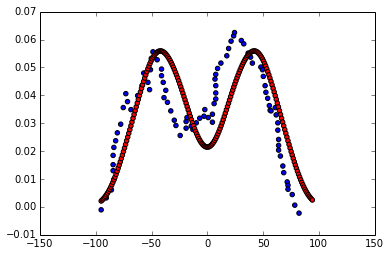

In [90]:
LARS = np.loadtxt("../data/LARS2.txt")
x = LARS[:-17,0]
y_0 = LARS[:-17,1]/1.1E2
z = 0.029836
c =  299792.458
x_0 = x - c*z
model = np.loadtxt("model.dat")
x_t = model[:,0]*12.85
y_t = model[:,1]

scatter(x_0, y_0)
scatter(x_t, y_t, c='r')
print max(x_0)

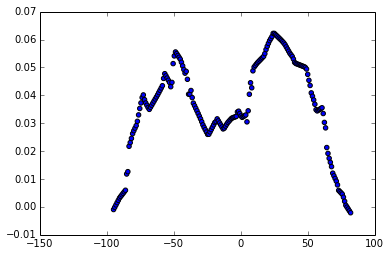

In [91]:
f = interp1d(x_0, y_0, kind="linear")
x_new = linspace(-95, 82, 200)
y_new = f(x_new)
scatter(x_new, y_new)

# Defining likelihood

In [92]:
def likelihood(y_obs, y_model):
    chi_squared = (1.0/2.0)*sum((y_obs-y_model)**2)
    return exp(-chi_squared)

# Function that returns the analytic solution 

In [93]:
def my_model(tau, vel, angle):
    f = open("values", "w")
    f.write(("%f \t %f \t %f \n")% (tau, vel, angle))
    f.close()
    !./analytic_solution.x > model.dat
    data_m = np.loadtxt("model.dat")
    x_teo = data_m[:,0]*12.85
    y_teo = data_m[:,1]
    return x_teo, y_teo
#x1, y1 = my_model(100000,50,45)
#print len(y1)

# MCMC core

In [94]:
tau_walk = empty((0)) #this is an empty list to keep all the steps
vel_walk = empty((0))
angle_walk = empty((0))
l_walk = empty((0))

tau_walk = append(tau_walk, 100000)
vel_walk = append(vel_walk, 50)
angle_walk = append(angle_walk, 45)

x_init, y_init = my_model(tau_walk[0], vel_walk[0], angle_walk[0])
l_walk = append(l_walk, likelihood(y_new, y_init))
print tau_walk
print vel_walk
print angle_walk
print l_walk

# 100000.000000 50.000000 0.785398
[ 100000.]
[ 50.]
[ 45.]
[ 0.99386751]


In [ ]:
n_iterations = 20000 #this is the number of iterations I want to make
for i in range(n_iterations):
    tau_prime = np.random.normal(tau_walk[i], 1000) 
    vel_prime = np.random.normal(vel_walk[i], 5)
    angle_prime = np.random.normal(angle_walk[i], 5)

    
    x_init, y_init = my_model(tau_walk[i], vel_walk[i], angle_walk[i])
    x_prime, y_prime = my_model(tau_prime, vel_prime, angle_prime)
    
    l_prime = likelihood(y_new, y_prime)
    l_init = likelihood(y_new, y_init)
    
    alpha = l_prime/l_init
    if(alpha>=1.0):
        tau_walk  = append(tau_walk,tau_prime)
        vel_walk  = append(vel_walk,vel_prime)
        angle_walk  = append(angle_walk,angle_prime)
        l_walk = append(l_walk, l_prime)
    else:
        beta = random.random()
        if(beta<=alpha):
            tau_walk = append(tau_walk,tau_prime)
            vel_walk = append(vel_walk,vel_prime)
            angle_walk  = append(angle_walk,angle_prime)
            l_walk = append(l_walk, l_prime)
        else:
            tau_walk = append(tau_walk,tau_walk[i])
            vel_walk = append(vel_walk,vel_walk[i])
            angle_walk = append(angle_walk,angle_walk[i])
            l_walk = append(l_walk, l_init)

# 45.000000 50.000000 0.785398


In [103]:
max_likelihood_id = argmax(l_walk)
best_tau = tau_walk[max_likelihood_id]
best_vel = vel_walk[max_likelihood_id]
best_angle = angle_walk[max_likelihood_id]
print (l_walk[max_likelihood_id])
print best_tau
print best_vel
print best_angle

0.994616505057
33.881756882
45.8595647085
33.881756882


# 51.350710 -8.740337 0.896239


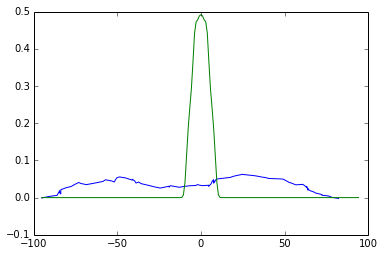

In [99]:
best_x, best_y = my_model(best_tau, best_vel, best_angle)
plot(x_0, y_0)
plot(best_x, best_y)

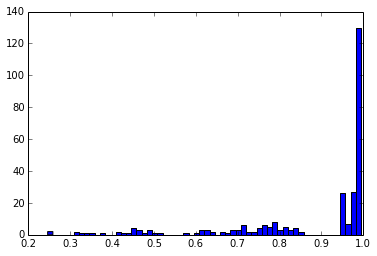

In [106]:
histo = hist(l_walk, bins=60)

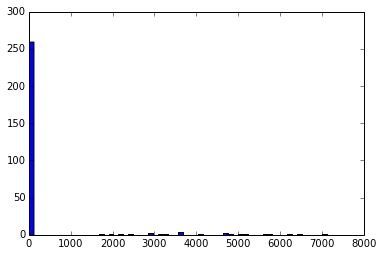

In [107]:
histo = hist(tau_walk, bins=60)